Problem 1 (50 pts)

AlexNet is originally proposed for 227*227 image sizes. It may be too complex for the CIFAR-10 dataset, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Report the training loss, validation loss, and validation accuracy. Also, report the number of parameters in your modified version of AlexNet and compare it against the number of parameters in the original AlexNet architectures. Here is a good reference guide to AlexNet: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guideLinks to an external site.

Explore the option of applying Dropout techniques for training your customized AlexNet. Compare the training and validation results against the baseline model without any dropout.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

# Define the simplified AlexNet model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, use_dropout=False):
        super(SimplifiedAlexNet, self).__init__()
        self.use_dropout = use_dropout

        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.classifier(x)
        return x

# Transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading and loading CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the network
net = SimplifiedAlexNet(use_dropout=True)

# Check if GPU is available and move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)



Files already downloaded and verified
Files already downloaded and verified


Epoch 1, Training Loss: 1.704, Validation Loss: 1.429
Epoch 2, Training Loss: 1.339, Validation Loss: 1.188
Epoch 3, Training Loss: 1.175, Validation Loss: 1.095
Epoch 4, Training Loss: 1.063, Validation Loss: 1.006
Epoch 5, Training Loss: 0.982, Validation Loss: 0.968
Epoch 6, Training Loss: 0.918, Validation Loss: 0.950
Epoch 7, Training Loss: 0.857, Validation Loss: 0.894
Epoch 8, Training Loss: 0.807, Validation Loss: 0.854
Epoch 9, Training Loss: 0.763, Validation Loss: 0.846
Epoch 10, Training Loss: 0.728, Validation Loss: 0.829
Finished Training


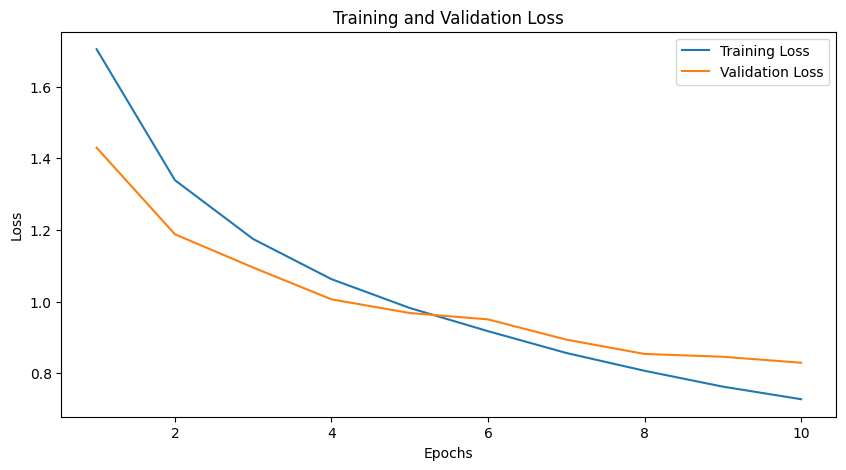

In [10]:
import matplotlib.pyplot as plt
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times

    net.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    net.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Training')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the model's state dictionary
torch.save(net.state_dict(), './simplified_alexnet_state_dict.pth')


In [11]:
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final Accuracy of the network on the 10000 test images: {final_accuracy:.2f}%')

Final Accuracy of the network on the 10000 test images: 71.36%


Epoch 1, Training Loss: 1.615, Validation Loss: 1.271
Epoch 2, Training Loss: 1.140, Validation Loss: 1.092
Epoch 3, Training Loss: 0.932, Validation Loss: 0.950
Epoch 4, Training Loss: 0.784, Validation Loss: 0.844
Epoch 5, Training Loss: 0.672, Validation Loss: 0.951
Epoch 6, Training Loss: 0.566, Validation Loss: 0.837
Epoch 7, Training Loss: 0.476, Validation Loss: 0.849
Epoch 8, Training Loss: 0.395, Validation Loss: 0.978
Epoch 9, Training Loss: 0.326, Validation Loss: 1.020
Epoch 10, Training Loss: 0.270, Validation Loss: 1.127
Finished Training without Dropout


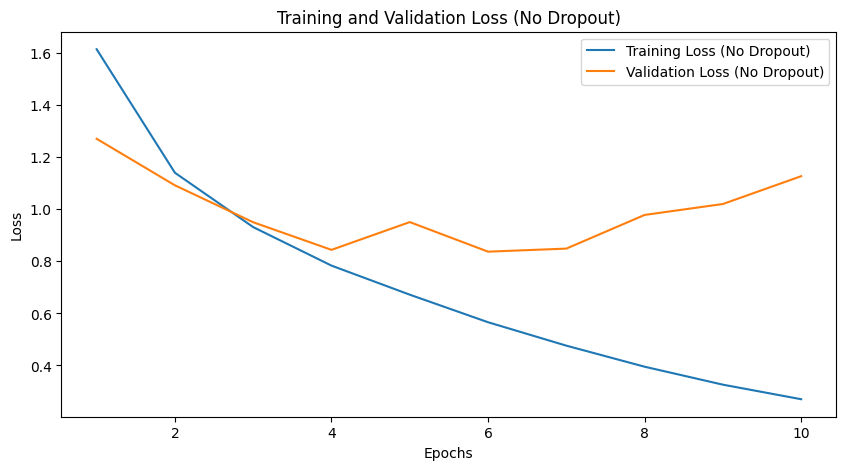

In [2]:
import matplotlib.pyplot as plt

# Assuming the provided code snippet is executed in the same Python session/environment
net_nodropout = SimplifiedAlexNet(use_dropout=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_nodropout.parameters(), lr=0.001)
net_nodropout.to(device)
# Initialize lists to store losses per epoch for the model without dropout
train_losses_nodropout = []
val_losses_nodropout = []

# Training and validation loop for the model without dropout
for epoch in range(10):  # loop over the dataset multiple times

    net_nodropout.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)  # Use the device variable

        optimizer.zero_grad()

        outputs = net_nodropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(trainloader)
    train_losses_nodropout.append(avg_train_loss)

    # Validation phase
    net_nodropout.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)  # Use the device variable
            outputs = net_nodropout(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(testloader)
    val_losses_nodropout.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Training without Dropout')

# Plotting the training and validation loss for the model without dropout
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses_nodropout, label='Training Loss (No Dropout)')
plt.plot(range(1, 11), val_losses_nodropout, label='Validation Loss (No Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (No Dropout)')
plt.legend()
plt.show()


In [3]:
net_nodropout.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net_nodropout(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final Accuracy of the network on the 10000 test images: {final_accuracy:.2f}%')

Final Accuracy of the network on the 10000 test images: 72.57%


Problem 2 (50 pts)

The baseline model we did in lectures is called ResNet-11. Build a new version of ResNet (ResNet-18). Train it on CIFAR-10. Plot the training loss, validation loss, and validation accuracy. Compare the classification accuracy, and model size across the two versions of ResNet (11, 18). How does the complexity grow as you increase the network depth?

You can find some references for ResNet 18 here:

https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorchLinks to an external site.

Explore the dropout option for the two networks and report your training results and validation accuracy.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, include_dropout=False):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.5) if include_dropout else nn.Identity()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

def resnet18(include_dropout=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], include_dropout=include_dropout)

# CIFAR-10 data loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


Epoch 1, Training Loss: 1.486, Validation Loss: 1.077
Epoch 2, Training Loss: 0.980, Validation Loss: 0.937
Epoch 3, Training Loss: 0.730, Validation Loss: 0.837
Epoch 4, Training Loss: 0.548, Validation Loss: 0.675
Epoch 5, Training Loss: 0.405, Validation Loss: 0.823
Epoch 6, Training Loss: 0.298, Validation Loss: 0.758
Epoch 7, Training Loss: 0.193, Validation Loss: 0.880
Epoch 8, Training Loss: 0.134, Validation Loss: 0.998
Epoch 9, Training Loss: 0.101, Validation Loss: 1.057
Epoch 10, Training Loss: 0.072, Validation Loss: 0.963
Epoch 11, Training Loss: 0.059, Validation Loss: 0.933
Epoch 12, Training Loss: 0.051, Validation Loss: 0.955
Epoch 13, Training Loss: 0.044, Validation Loss: 1.012
Epoch 14, Training Loss: 0.029, Validation Loss: 0.926
Epoch 15, Training Loss: 0.018, Validation Loss: 0.866
Epoch 16, Training Loss: 0.012, Validation Loss: 0.831
Epoch 17, Training Loss: 0.011, Validation Loss: 1.003
Epoch 18, Training Loss: 0.009, Validation Loss: 0.893
Epoch 19, Training 

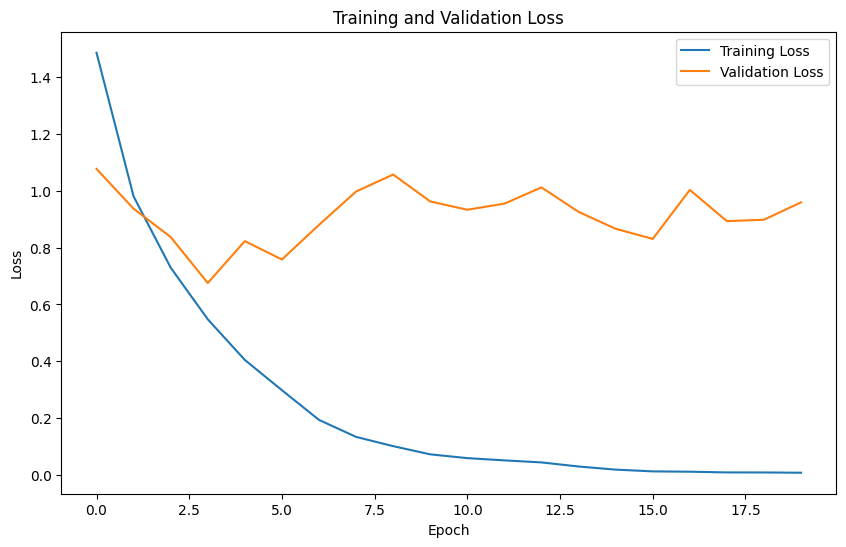

In [10]:
# Model, criterion, optimizer
net = resnet18(include_dropout=True).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(20):  # loop over the dataset multiple times

    net.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    net.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].cuda(), data[1].cuda()
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')
torch.save(net.state_dict(), 'resnet18_with_dropout.pth')
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [11]:
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final Accuracy of the network on the 10000 test images: {final_accuracy:.2f}%')

Final Accuracy of the network on the 10000 test images: 79.42%


Epoch 1, Training Loss: 1.361, Validation Loss: 1.146
Epoch 2, Training Loss: 0.872, Validation Loss: 0.852
Epoch 3, Training Loss: 0.634, Validation Loss: 0.692
Epoch 4, Training Loss: 0.449, Validation Loss: 0.742
Epoch 5, Training Loss: 0.293, Validation Loss: 0.790
Epoch 6, Training Loss: 0.176, Validation Loss: 0.952
Epoch 7, Training Loss: 0.109, Validation Loss: 1.007
Epoch 8, Training Loss: 0.059, Validation Loss: 0.882
Epoch 9, Training Loss: 0.040, Validation Loss: 0.916
Epoch 10, Training Loss: 0.026, Validation Loss: 0.905
Epoch 11, Training Loss: 0.017, Validation Loss: 0.856
Epoch 12, Training Loss: 0.011, Validation Loss: 0.846
Epoch 13, Training Loss: 0.004, Validation Loss: 0.813
Epoch 14, Training Loss: 0.002, Validation Loss: 0.803
Epoch 15, Training Loss: 0.001, Validation Loss: 0.818
Epoch 16, Training Loss: 0.001, Validation Loss: 0.816
Epoch 17, Training Loss: 0.001, Validation Loss: 0.823
Epoch 18, Training Loss: 0.002, Validation Loss: 0.833
Epoch 19, Training 

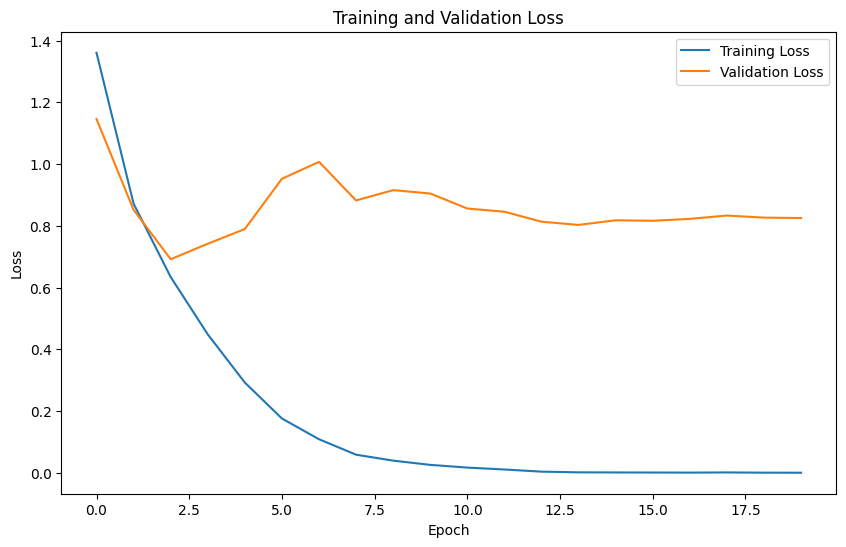

In [7]:
import matplotlib.pyplot as plt
# Model, criterion, optimizer
net_without_dropout = resnet18(include_dropout=False).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_without_dropout.parameters(), lr=0.001, momentum=0.9)



# Initialize lists to store the losses
train_losses = []
val_losses = []

# Assuming the provided training and validation loop is executed

# Modify your training and validation loop to include:
for epoch in range(20):  # loop over the dataset multiple times
    net_without_dropout.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        outputs = net_without_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)  # Append the average loss to the list

    net_without_dropout.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].cuda(), data[1].cuda()
            outputs = net_without_dropout(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)  # Append the average validation loss to the list

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [8]:
 net_without_dropout.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs =  net_without_dropout(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final Accuracy of the network on the 10000 test images: {final_accuracy:.2f}%')

Final Accuracy of the network on the 10000 test images: 81.00%
